In [1]:
import numpy as np,os,sys,inspect
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_breast_cancer, make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict,ShuffleSplit,
                                     StratifiedShuffleSplit, RandomizedSearchCV,cross_validate ,StratifiedKFold)
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, matthews_corrcoef, make_scorer
import matplotlib.pyplot as plt
from utils import corrupt_label, load_mat, Logit, linearly_sep2D, NoisyEstimator, create_noise, my_loss, log_loss

## Steps
+ Reproduce 2D artificial linearly-seperable dataset result with log-hat loss. **DONE** - .9909
+ In a linearly seperable dataset, show it's possible to achieve 100% acc with regular LR, given enough data. (In accordance with a paper which suggests this for symmetric loss, uniform noise and zero Bayes error. Here, although we don't have symmetric loss, Bayes error is zero.) **DONE**. 
+ Show variance of decision boundary of LR & Logit for different noise in Y.
+ Does PN, NP hyparam of Logit converge to actual noise level, given enough data? **DONE**
+ How does Logit (& LR) *truly* react to non-uniform noise rate? (PN /= NP) **DONE**
+ How does Logit (& LR) react to dataset imbalance?
+ What if artificially make Logit loss symmetric? abs(ls)==abs(nls)

## Observations
+ Regular LR on symmetric noise: Given 5000 samples, acc reaches .999.
+ Logit seems pointless for symmetric noise, since LR seems better. For non-symmetric, Logit is lot better. 
+ Hyparams do seem to converge to actual noise level, tried on 12_000 samples.
+ **My Loss** beats when NP>PN, but sucks big time in everything else

(array([0, 1]), array([6093, 6088])) 12181


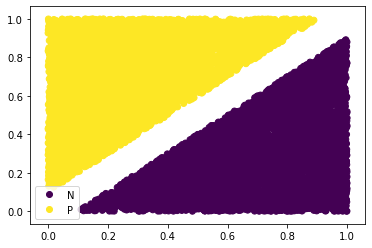

In [77]:
X,y = linearly_sep2D(n_samples=15_000,dist=.1)  
print(np.unique(y,return_counts=True),len(X))
sc = plt.scatter(X[:,0],X[:,1],c=y);
plt.legend(handles=sc.legend_elements()[0], labels=['N','P']);

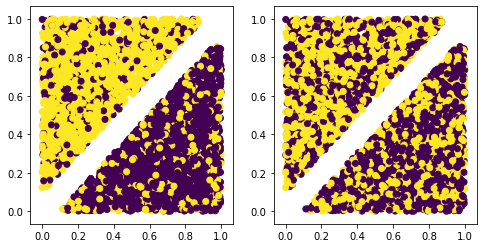

In [3]:
y20 = create_noise(y,PN=.2,NP=.2)
y40 = create_noise(y,PN=.4,NP=.4)
f,(ax1,ax2) = plt.subplots(ncols=2,figsize=(8,4))
ax1.scatter(X[:,0],X[:,1],c=y20);
ax2.scatter(X[:,0],X[:,1],c=y40);

In [4]:
PN,NP = .4,.4
grid = GridSearchCV(Logit(PN,NP,C=np.inf,robust=True),
                    {'PN':[.1,.2,.3,.4],'NP':[.1,.2,.3,.4]},cv=ShuffleSplit(n_splits=3,test_size=.2))
clf = NoisyEstimator(grid,PN,NP)
cv = StratifiedShuffleSplit(n_splits=10,test_size=.2)
r = cross_val_score(clf,X,y,cv=cv)
r.mean(),r.std()

(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))


(0.9915647921760392, 0.013661881974590574)

## Regular LR on linearly seperable dataset

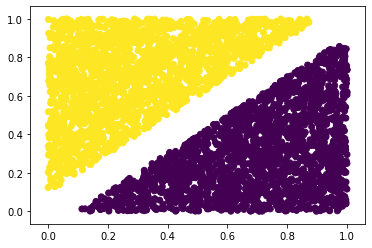

In [5]:
lr = LogisticRegression(C=np.inf).fit(X,y40)
yp = lr.predict(X)
plt.scatter(X[:,0],X[:,1],c=yp);

In [6]:
PN,NP = .40,.40
grid = GridSearchCV(LogisticRegression(max_iter=1000),
                    {'C':[1e-3,1e-2,1e-1,1,10,100,1000,np.inf]},cv=ShuffleSplit(n_splits=1,test_size=.2))
clf = NoisyEstimator(grid,PN,NP)
cv = StratifiedShuffleSplit(n_splits=10,test_size=.2)
r = cross_val_score(clf,X,y,cv=cv)
r.mean(),r.std()

(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))


(0.9991442542787287, 0.0025672371638141844)

## Not-uniform noise rate for LR and Logit
+ Regular LR's performance takes a big hit due to asymmetric (.1,.3) noise, 99.1 -> 90.0. But Logit still maintains around 99.5% acc.

In [32]:
PN,NP = .30,.10
grid = GridSearchCV(Logit(PN,NP,C=np.inf,robust=True),
                    {'PN':[.1,.2,.3,.4],'NP':[.1,.2,.3,.4]},cv=ShuffleSplit(n_splits=3,test_size=.2))
clf = NoisyEstimator(grid,PN,NP)
cv = StratifiedShuffleSplit(n_splits=10,test_size=.2)
r = cross_val_score(clf,X,y,cv=cv)*100
r.mean(),r.std()

(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))
(array([0, 1]), array([1640, 1629]))


(98.43520782396088, 1.0484978798235474)

(array([0, 1]), array([2091, 2012]))
(array([0, 1]), array([2091, 2012]))


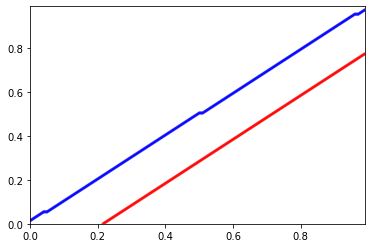

In [69]:
PN,NP = .15,.35
lr = LogisticRegression(max_iter=1000,penalty='none')
log = Logit(PN,NP,C=np.inf,robust=True)
for clf,col in zip([lr,log],['red','blue']):
    clf = NoisyEstimator(clf,PN,NP).fit(X,y)
    xx,yy = np.meshgrid(np.arange(0,1,.01),np.arange(0,1,.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contour(xx,yy,Z,alpha=.5,colors=col);

In [70]:
lr.coef_, log.coef_

(array([[-2.37571684,  2.38374228]]), array([[-21.59010083,  22.06609688]]))

## Hyparam of Logit

In [97]:
PN,NP = .4,.1
grid = GridSearchCV(Logit(C=np.inf,robust=True),
                    {'PN':np.linspace(.05,.45,9),'NP':np.linspace(.05,.45,9)},cv=ShuffleSplit(n_splits=5,test_size=.2))
clf = NoisyEstimator(grid,PN,NP).fit(X,y)
clf.estimator.best_params_

(array([0, 1]), array([6093, 6088]))


{'NP': 0.2, 'PN': 0.45}

In [98]:
rank = np.argsort(clf.estimator.cv_results_['rank_test_score'])[:10]
clf.estimator.cv_results_['mean_test_score'][rank]

array([0.74780468, 0.74755847, 0.74755847, 0.74731227, 0.74583504,
       0.74534263, 0.74427575, 0.74353714, 0.74304473, 0.73869512])

In [99]:
for k in rank:
    print(k,clf.estimator.cv_results_['params'][k])

35 {'NP': 0.2, 'PN': 0.45}
5 {'NP': 0.05, 'PN': 0.3}
6 {'NP': 0.05, 'PN': 0.35000000000000003}
15 {'NP': 0.1, 'PN': 0.35000000000000003}
4 {'NP': 0.05, 'PN': 0.25}
16 {'NP': 0.1, 'PN': 0.4}
7 {'NP': 0.05, 'PN': 0.4}
26 {'NP': 0.15000000000000002, 'PN': 0.45}
14 {'NP': 0.1, 'PN': 0.3}
25 {'NP': 0.15000000000000002, 'PN': 0.4}


## Logit & LR in imbalance data
+ When no noise, even under high imbalance (IR=15), both performs same.
+ IR=15,Even in small symmetric noise, Logit outperforms LR.
+ IR=15,For asymmetric noise: when PN>NP, LR's performance gets worse. But if NP>PN i.e classes gets balanced, they perform equally well.
+ When imb low (IR=5.0 & 3.0), in NP>PN case, LR emphasizes P, no of FP increases, but Logit performs well. When PN>NP, LR still performs worse, but FN increases this time.

(array([0, 1]), array([10256, 10066])) 20322
[0 1] [10256  3387] 13643 3.02804842043106


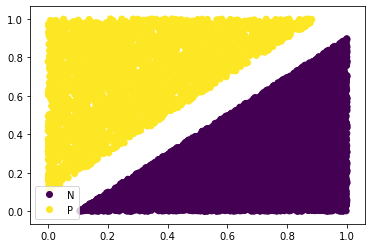

In [90]:
X,y = linearly_sep2D(n_samples=5_000,dist=.1)  
N = len(X)
print(np.unique(y,return_counts=True),len(X))

idx1 = np.random.choice(np.argwhere(y==1).reshape(-1),size=N//6,replace=False)
X1,y1 = X[idx1],y[idx1]
X2,y2 = X[y==0],y[y==0]
X,y = np.concatenate([X1,X2],axis=0),np.concatenate([y1,y2],axis=0)
idx = np.random.permutation(len(y))
X,y = X[idx],y[idx]
n,f = np.unique(y,return_counts=True)
print(n,f,len(X),f.max()/f.min())

sc = plt.scatter(X[:,0],X[:,1],c=y);
plt.legend(handles=sc.legend_elements()[0], labels=['N','P']);

[10585  3058] 3.461412688031393


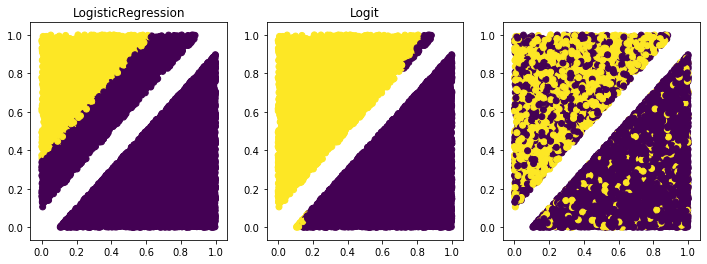

In [93]:
PN,NP = 0.4,0.1
lr = LogisticRegression(max_iter=1000,penalty='none')
log = Logit(PN,NP,C=np.inf,robust=True)
f,axs = plt.subplots(ncols=3,figsize=(12,4))
yn = create_noise(y,PN,NP)
f= np.bincount(yn)
print(f,f.max()/f.min())
for clf,ax in zip([lr,log],axs):
    ax.set_title(clf.__class__.__name__)
    clf = clf.fit(X,yn)
    ax.scatter(X[:,0],X[:,1],c=clf.predict(X));
axs[-1].scatter(X[:,0],X[:,1],c=yn);

In [ ]:
X,y =  make_classification(n_samples=15000,n_features=5,n_informative=5,n_redundant=0)  #linearly_sep2D(n_samples=15_000,dist=.1)  
PN,NP = .4,.4
scores = {'mathew':make_scorer(matthews_corrcoef),'f1':make_scorer(f1_score),'acc':make_scorer(accuracy_score)}
for ir in [2,4,8,16,32]:
    print("IR:",ir)
    sz = (y==1).sum() - (y==0).sum()/ir
    idx = np.random.choice(np.argwhere(y==1).reshape(-1),size=int(sz),replace=False)
    mask = np.ones_like(y,dtype='bool')
    mask[idx] = 0
    Xim,yim = X[mask],y[mask]
    probP = yim.sum()/len(y)
    lr = Logit(PN,NP,C=np.inf,robust=True,func=my_loss,probP=probP)
    log = Logit(PN,NP,C=np.inf,robust=True,func=log_loss)
    models = {'my':lr,'nips':log}
    
    for name,clf in {'my':lr,'nips':log}.items():
        print(name)
        clf = NoisyEstimator(clf,PN,NP)
        res = cross_validate(clf,Xim,yim,cv=StratifiedShuffleSplit(n_splits=10,test_size=.2),
                           scoring=scores)
        for k in scores:
            r = res[f"test_{k}"]
            print(k,r.mean(),r.std())
        print()
    print()

IR: 2
my
mathew 0.43696583618025997 0.03676631067482498
f1 0.4512947777229078 0.06479751413107146
acc 0.7586482881280568 0.01490950544621056

nips
mathew 0.5717305730761285 0.01706434814950591
f1 0.6978877265559317 0.011915065853375196
acc 0.8153401511783015 0.007392433391087281


IR: 4
my
mathew 0.29875643972993743 0.08002375360816773
f1 0.31422716789005134 0.08905195723220506
acc 0.8203842049092851 0.015815628863647103

nips
mathew 0.5188399638355432 0.036776558961079786
f1 0.5850004882267134 0.028884563967856738
acc 0.8599786552828175 0.010356037968587594


IR: 8
my
mathew 0.2699446701703132 0.03601508393617728
f1 0.2960067839846795 0.04061182987074906
acc 0.8869590989922941 0.005992825217486551

nips
